<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Utilities" data-toc-modified-id="Utilities-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Utilities</a></span></li><li><span><a href="#Video-in-Notebooks" data-toc-modified-id="Video-in-Notebooks-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Video in Notebooks</a></span></li><li><span><a href="#Normalized-Sum-of-Squared-Differences-and-Normalized-Cross-Correlation" data-toc-modified-id="Normalized-Sum-of-Squared-Differences-and-Normalized-Cross-Correlation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Normalized Sum of Squared Differences and Normalized Cross-correlation</a></span><ul class="toc-item"><li><span><a href="#Sum-of-Squared-Differences" data-toc-modified-id="Sum-of-Squared-Differences-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Sum of Squared Differences</a></span></li><li><span><a href="#Normalized-Sum-of-Squared-Distances" data-toc-modified-id="Normalized-Sum-of-Squared-Distances-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Normalized Sum of Squared Distances</a></span></li><li><span><a href="#Normalized-Cross-Correlation" data-toc-modified-id="Normalized-Cross-Correlation-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Normalized Cross-correlation</a></span></li><li><span><a href="#Faster-Normalized-Cross-Correlation-in-Python" data-toc-modified-id="Faster-Normalized-Cross-Correlation-in-Python-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Faster Normalized Cross-correlation in Python</a></span></li><li><span><a href="#Template-Matching" data-toc-modified-id="Template-Matching-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Template Matching</a></span></li></ul></li><li><span><a href="#Correlation-based-Tracking" data-toc-modified-id="Correlation-based-Tracking-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Correlation based Tracking</a></span><ul class="toc-item"><li><span><a href="#Tracking-the-Ball" data-toc-modified-id="Tracking-the-Ball-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Tracking the Ball</a></span></li><li><span><a href="#(BONUS)-Speeding-Up-Correlation-based-Tracking" data-toc-modified-id="(BONUS)-Speeding-Up-Correlation-based-Tracking-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>(BONUS) Speeding Up Correlation based Tracking</a></span></li><li><span><a href="#Simulating-an-Optical-Mouse" data-toc-modified-id="Simulating-an-Optical-Mouse-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Simulating an Optical Mouse</a></span></li></ul></li><li><span><a href="#Some-Final-Notes-on-Tracking" data-toc-modified-id="Some-Final-Notes-on-Tracking-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Some Final Notes on Tracking</a></span></li></ul></div>

# CV LabExercise: Image Motion

## 1. Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Video
from os.path import isfile
import wget
import imageio
from pprint import pprint
from scipy.ndimage import gaussian_filter, generic_filter, uniform_filter, correlate
from skimage.feature import match_template
from skimage.color import rgb2gray


Hidden in this cell are some $\LaTeX$ macros
$\newcommand{\v}[1]{\mathbf #1}$
$\newcommand{\hv}[1]{\widetilde{\mathbf #1}}$
$\newcommand{\setR}{\mathbb R}$
$\newcommand{\set}[1]{\mathcal #1}$
$\newcommand{\T}{^\top}$
$\newcommand{\inv}{^{-1}}$
$\newcommand{\pfrac}[2]{\frac{\partial #1}{\partial #2}}$
$\DeclareMathOperator{\ssd}{ssd}$
$\DeclareMathOperator{\nssd}{nssd}$
$\DeclareMathOperator{\ncc}{ncc}$
$\newcommand{\one}{\mathbb{I}}$
$\DeclareMathOperator{\nom}{nom}$
$\DeclareMathOperator{\den}{den}$


## 2. Utilities

In [2]:
def imshow_row(imttllist, axs=False):
    n = len(imttllist)
    for i, imttl in enumerate(imttllist):
        if imttl is None:
            continue
        im, ttl = imttl
        plt.subplot(1,n,i+1)
        plt.imshow(im, cmap='gray')
        if not axs:
            plt.axis('off')
        plt.title(ttl)

## 3. Video in Notebooks

Given the url of a video file you can play it in a Jupyter notebook:

In [3]:
url = "https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/ball2.mp4"
Video(url)

When processing video we will need to be able to access the individual frames (images) in a video. To do so we will first download the video shown above to your local directory:

In [4]:
if not isfile("ball2.mp4"):
    print("Downloading the video")
    wget.download(url)

To read mp4 files we will use the ``imageio`` package. You may need to install this package: specifically the package `imageio-ffmpeg`, which you can install with pip. Depending on your operating system you may also need to explicitly install ffmpeg itself; e.g. on Ubuntu you might use `sudo apt install ffmpeg`. 

In [5]:
ball_reader = imageio.get_reader("ball2.mp4")

With the reader we can access the individual frames in the video. Below we retrieve every other 4 frames from the video starting at frame 40 (before that little is seen). Please note that we must set an interactive backend to do updates in a plot. Below i have chosen for the ``notebook`` backend. Please do not forget to switch to the ``inline`` backend after you have run the code (but not in the same cell!).

<IPython.core.display.Javascript object>


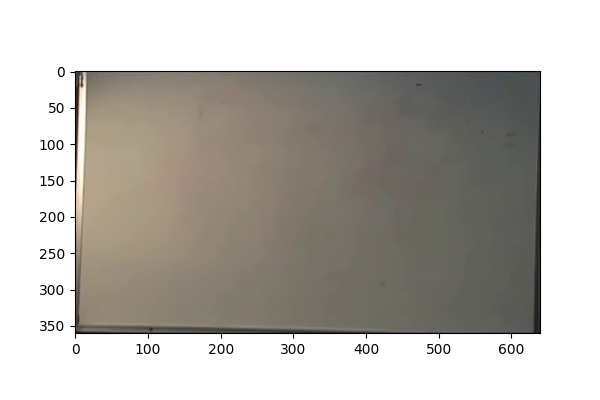

In [6]:
%matplotlib notebook
no_frames = ball_reader.count_frames()
start_frame = 40
step_frame = 4
stop_frame = no_frames

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
im = ball_reader.get_data(start_frame)
img = ax.imshow(im)
fig.canvas.draw()



for i in range(start_frame, no_frames, step_frame):
    im = ball_reader.get_data(i)
    img.set_data(im)
    
    ## here you could do some processing of the incoming frames
    ## and possibly do some drawing
    
    fig.canvas.draw();
    

In [7]:
%matplotlib inline

## 4. Normalized Sum of Squared Differences and Normalized Cross-correlation 

We start with a simple image: Gaussian filtered noise. And we select a small detail of size 32x32 as the image we would like to find with a correlation based method. In the figure below the detail to be found (and fixed in position) is outlined in red in the orginal image. A detail at some other position is outlined in blue. Both details are also shown.

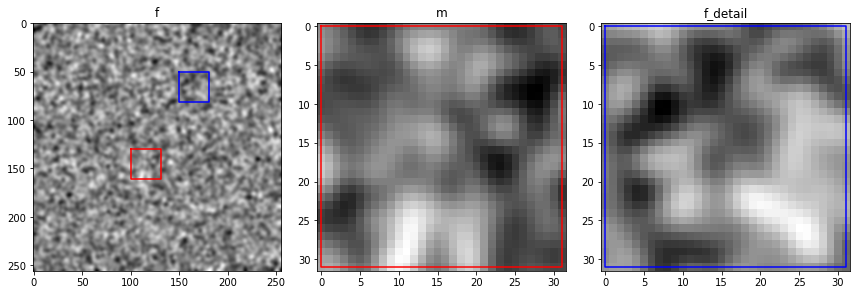

In [8]:
np.random.seed(378235)
f = gaussian_filter(np.random.randn(256, 256), 2)
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(f)
plt.gray()
plt.title('f')
x, y = 100, 130
size = 32
plt.plot( [x, x+size-1, x+size-1, x, x], [y, y, y+size-1, y+size-1, y], '-r')
xr, yr = 150, 50
plt.plot( [xr, xr+size-1, xr+size-1, xr, xr], [yr, yr, yr+size-1, yr+size-1, yr], '-b')

plt.subplot(132)
m = f[y:y+size, x:x+size]
plt.imshow(m);
plt.plot( [0, size-1, size-1, 0, 0], [0, 0, size-1, size-1, 0], '-r')
plt.title('m')

plt.subplot(133)
f_detail = f[yr:yr+size, xr:xr+size]
plt.imshow(f_detail);
plt.plot( [0, size-1, size-1, 0, 0], [0, 0, size-1, size-1, 0], '-b')
plt.title('f_detail')

plt.tight_layout();

### 4.1 Sum of Squared Differences

Next you have to calculate the sum of squared differences of the template ``m`` and detail ``f_detail``. Because we are going to use the ``generic_filter`` function to calculate the ssd for each shifted version of ``f_detail`` we need to write the function ``calculate_ssd`` to have the flattened arrays as input (i.e. the array reshaped in one dimensional array).

In [9]:
def calculate_ssd(f_detail_flattened, m_flattened):
    """return the average of the sum of squared distances for the two arguments"""
    ssd = 0
    for i in range(len(f_detail_flattened)):
        ssd += (f_detail_flattened[i] - m_flattened[i]) ** 2
    return ssd / len(f_detail_flattened)

In [10]:
# Tests for personal use. Codegrade will use more and different tests!
v1 = v2 = np.random.normal(0, 1, 10)
assert np.isclose(calculate_ssd(v1, v2), 0.0)

v1 = np.arange(5)
v2 = np.zeros(5)
assert np.isclose(calculate_ssd(v1, v2), 6)

x, y = 100, 130
size = 32
xr, yr = 150, 50
m = f[y:y+size, x:x+size]
f_detail = f[yr:yr+size, xr:xr+size]

assert np.allclose(calculate_ssd(f_detail.flatten(), m.flatten()), 58.4205 / 32**2)
assert np.allclose(calculate_ssd(m.flatten(), m.flatten()), 0)

Next we can use the ``generic_filter`` function to calculate the ssd for each translated version of ``f_detail`` and fixed template ``m``. 

116 146


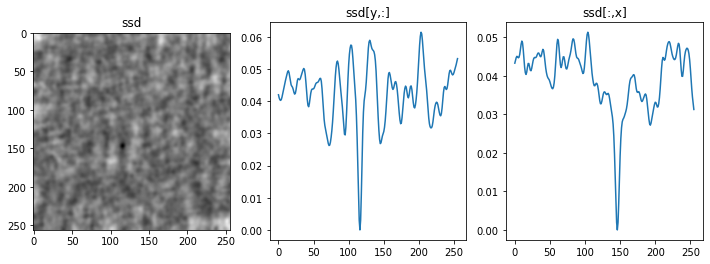

In [11]:
ssd = generic_filter(f, calculate_ssd, 32, extra_arguments=(m.flatten(),))
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(ssd)
plt.title('ssd')
y, x = np.unravel_index(np.argmin(ssd), ssd.shape[:2])
print(x,y)

plt.subplot(132)
plt.plot(ssd[y])
plt.title('ssd[y,:]')
plt.subplot(133)
plt.plot(ssd[:,x])
plt.title('ssd[:,x]');

In case you were expecting the minimal value to be at (100, 130) remember that the ``generic_filter`` considers neighborhoods centered in the middle of the template (i.e. at position (16, 16) of the 32x32 image details we are looking at. So the minimum at (116, 146) is consistent with our choice of the square neighborhood with top left corner at (100, 130).

### 4.2 Normalized Sum of Squared Distances

Next write the function ``calculate_nssd`` to calculate the normalized sum of squared distances.

In [12]:
def calculate_nssd(f_detail_flattened, m_flattened):
    """Return the normalized average sum of squared distances between the two arguments"""
    M = len(m_flattened)
    f_flat = (1/M) * sum(f_detail_flattened)
    m_flat = (1/M) * sum(m_flattened)
    
    s_f = np.sqrt((1/M) * sum((f_detail_flattened - f_flat) ** 2))
    m_f = np.sqrt((1/M) * sum((m_flattened - m_flat) ** 2))
    
    f_hat = (f_detail_flattened - f_flat) / s_f
    m_hat = (m_flattened - m_flat) / m_f
    
    nssd = 2 * (1 - (1 / M) * sum(f_hat * m_hat))
    return nssd

In [13]:
# Tests for personal use. Codegrade will use more and different tests!
v1 = v2 = np.random.normal(3, 2, 10)
assert np.isclose(calculate_nssd(v1, v2), 0.0)

v1 = np.arange(5)
v2 = np.array([1,2,1,2,1])
assert np.isclose(calculate_nssd(v1, v2), 2.0)

x, y = 100, 130
size = 32
xr, yr = 150, 50
m = f[y:y+size, x:x+size]
f_detail = f[yr:yr+size, xr:xr+size]

assert np.allclose(calculate_nssd(f_detail.flatten(), m.flatten()), 2.267358173713738)

116 146


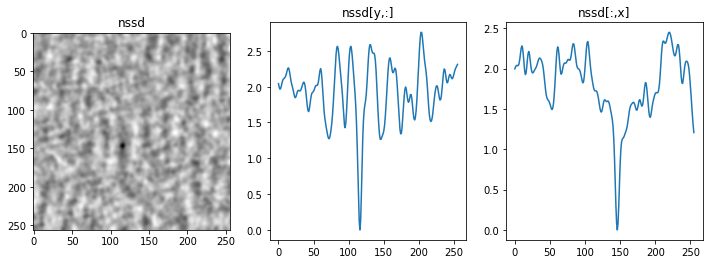

In [14]:
# This cell takes some time to run... (about 10 seconds on my computer)
nssd = generic_filter(f, calculate_nssd, 32, extra_arguments=(m.flatten(),))
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(nssd)
plt.title('nssd')
y, x = np.unravel_index(np.argmin(nssd), nssd.shape[:2])
print(x,y)

plt.subplot(132)
plt.plot(nssd[y])
plt.title('nssd[y,:]')
plt.subplot(133)
plt.plot(nssd[:,x])
plt.title('nssd[:,x]');

### 4.3 Normalized Cross-Correlation

Write the function `calculate_ncc`, to calculate the normalized cross-correlation of two sequences.

In [15]:
def calculate_ncc(f_detail_flattened, m_flattened):
    """Return the normalized cross-correlation between the two arguments."""
    M = len(m_flattened)
    f_flat = (1/M) * sum(f_detail_flattened)
    m_flat = (1/M) * sum(m_flattened)
    
    s_f = np.sqrt((1/M) * sum((f_detail_flattened - f_flat) ** 2))
    m_f = np.sqrt((1/M) * sum((m_flattened - m_flat) ** 2))
    
    f_hat = (f_detail_flattened - f_flat) / s_f
    m_hat = (m_flattened - m_flat) / m_f
    
    ncc = (1/M) * sum(f_hat * m_hat)
    return ncc

In [16]:
# Tests for personal use. Codegrade will use more and different tests!
v1 = v2 = np.random.normal(3, 2, 10)
assert np.isclose(calculate_ncc(v1, v2), 1.0)

v1 = np.arange(5)
v2 = np.array([1,2,1,2,1])
assert np.isclose(calculate_ncc(v1, v2), 0.0)

x, y = 100, 130
size = 32
xr, yr = 150, 50
m = f[y:y+size, x:x+size]
f_detail = f[yr:yr+size, xr:xr+size]

assert np.allclose(calculate_ncc(f_detail.flatten(), m.flatten()), -0.1336790868568689)

116 146


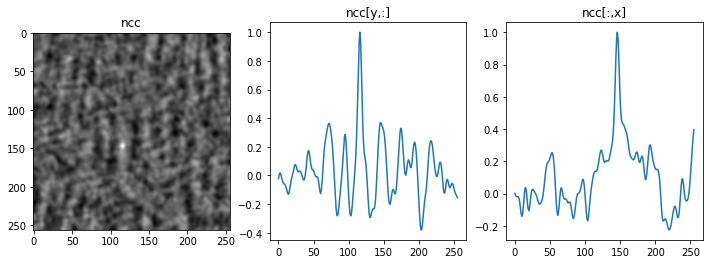

In [17]:
ncc = generic_filter(f, calculate_ncc, 32, extra_arguments=(m.flatten(),))
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(ncc)
plt.title('ncc')
y, x = np.unravel_index(np.argmax(ncc), ncc.shape[:2])
print(x,y)

plt.subplot(132)
plt.plot(ncc[y])
plt.title('ncc[y,:]')
plt.subplot(133)
plt.plot(ncc[:,x])
plt.title('ncc[:,x]');

In the lecture notes it is derived that:
\begin{align}
\mbox{nssd} = 2 ( 1 - \mbox{ncc})
\end{align}
Let's test that:

In [18]:
np.allclose(nssd, 2*(1-ncc))

True

### 4.4 Faster Normalized Cross-correlation in Python

The normalized cross-correlation is quite slow. In the [lecture notes](https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/LectureNotes/CV/Motion/CorrelationTracking.html) the derivation is given leading to the following recipe to calculate the ncc using convolutions:

1. Normalize the mask, i.e. subtract the mean and divide by the
   standard deviation:
   \begin{align} 
      \hat m(\v x) = \frac{m(\v x) - \bar m}{s_m}
   \end{align}

1. Let $f$ be the image where to search for the mask. Calculate the
   following convolutions:
   \begin{align} 
      \nom &= f \ast \hat m^\star \\
      \den_1 &= M^2\;f^2 \ast [\set M]^\star \\
      \den_2 &= M\;f \ast [\set M]^\star \\
   \end{align} 
   
1. Calculate the ncc image:
   \begin{align}
      ncc = \frac{\nom}{\sqrt{\den_1-\den_2^2}}
   \end{align}

1. Find the position $\v x^\star$ where $\ncc$ is maximal
   \begin{align}
       \v x^\star = \arg\max_{\v x} \ncc(\v x)
   \end{align}
  
Write the function `ncc_filter`, which computes the normalized cross-correlation much faster using convolutions (use the function `uniform_filter`).

In [19]:
def ncc_filter(f, m):
    """Return the normalized cross-correlation between f and m using convolutions."""
    M = len(m.flatten())
    print(M)
    m_flat = (1/M) * sum(m)
    m_f = np.sqrt((1/M) * sum((m - m_flat) ** 2))
    m_hat = (m - m_flat) / m_f
    nom = correlate(f, m_hat)
    den_1 = uniform_filter((M ** 2) * (f ** 2), len(m))
    den_2 = uniform_filter(M * f, len(m))
    ncc = nom / (np.sqrt(den_1 - den_2 ** 2))
    return ncc

In [20]:
# Tests for personal use. Codegrade will use more and different tests!
f_test = np.random.normal(2, 3, (256, 256))
m_test = np.random.normal(-1, 2, (32, 32))
test_ncc = generic_filter(f_test, calculate_ncc, 32, extra_arguments=(m_test.flatten(),))
test_fncc = ncc_filter(f_test, m_test)
assert np.allclose(test_ncc, test_fncc), "The output of your ncc_filter does not match that of calculate_ncc."

1024


AssertionError: The output of your ncc_filter does not match that of calculate_ncc.

1024
116 146


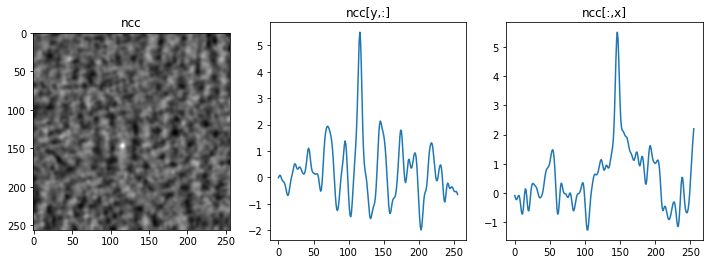

In [21]:
fncc = ncc_filter(f, m)
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(fncc)
plt.title('ncc')
y, x = np.unravel_index(np.argmax(fncc), fncc.shape[:2])
print(x,y)

plt.subplot(132)
plt.plot(fncc[y])
plt.title('ncc[y,:]')
plt.subplot(133)
plt.plot(fncc[:,x])
plt.title('ncc[:,x]');

In [22]:
# Check that your two methods give the same answer for the image we are working with.
assert np.allclose(ncc, fncc)
assert x==116
assert y==146

AssertionError: 

### 4.5 Template Matching

The normalized cross-correlation that you have developed in this exercise is known in Scikit Image (skimage) as ``match_template``.

116 146


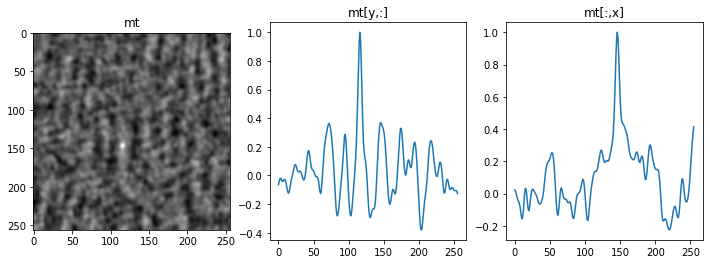

In [23]:
mt = match_template(f, m, pad_input=True, mode='reflect')
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(mt)
plt.title('mt')
y, x = np.unravel_index(np.argmax(mt), mt.shape[:2])
print(x,y)

plt.subplot(132)
plt.plot(mt[y])
plt.title('mt[y,:]')
plt.subplot(133)
plt.plot(mt[:,x])
plt.title('mt[:,x]');

In [24]:
np.allclose(fncc,mt) 
# for this to return True you have to set the named 
# argument ``mode='constant'`` both for the match_template function as 
# well as for the ``correlate`` and ``uniform_filter`` in the ``ncc_filter`` function.
# Looking at the difference image it is clear that it is a border problem!

False

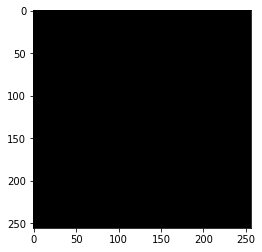

In [25]:
plt.imshow(abs(fncc-mt)<0.000000001); # to illustrate where the 'errors' are

## 5. Correlation based Tracking

### 5.1 Tracking the Ball

Remember the code to read and display a video file frame by frame? You finally have to use that code here!
We are going to track the ball in the video using template matching.

To do this, first implement the `find_template` function below, which finds a template `m` in the grayscale image `f` and returns the (x, y) coordinates of where the center of the template was found in the image. (Hint: the `match_template` function is most likely much faster than your own `ncc_filter` function)

In [26]:
def find_template(f, m):
    """
    Find the template m in the grayscale input image f.
    Return the coordinates as an (x, y) tuple.
    """
    match = match_template(f , m, pad_input = True)
    index = np.argmax(match)
    x = index % f.shape[1]
    y = int((index - x) / f.shape[1])
    return (x,y)

In [27]:
# Tests for personal use. Codegrade will use more and different tests!
f = rgb2gray(ball_reader.get_data(74))
m = f[60:86,30:56]
assert find_template(f, m) == (43, 73)

m = rgb2gray(ball_reader.get_data(40)[275:325,72:122])
f = rgb2gray(ball_reader.get_data(123))
assert find_template(f, m) == (201, 126)
f = rgb2gray(ball_reader.get_data(167))
assert find_template(f, m) == (248, 84)

Next we will use the `find_template` function to find a template over multiple frames and return all their coordinates. Implement the `track_motion` function below to do this. The `reader` can be used to extract frames from the video file; The `start_`, `step_` and `end_frame` determine which frames to check; And the `template_pos` and `template_size` tell you where the template can be found in the `start_frame`. The function should return a list of (x, y) tuples. One tuple per frame, representing where the template was found.

In [28]:
def track_motion_static(reader, start_frame, step_frame, end_frame, template_pos, template_size):
    """
    Determine the template in the start_frame and find it in all frames from start_frame to stop_frame
    (with an interval of step_frame). Return a list of (x,y) tuples indicating where the template was found
    in each frame.
    """
    templates = []
    im = rgb2gray(reader.get_data(start_frame))
    start_temp = im[template_pos[1]: template_pos[1] + template_size[1], template_pos[0]: template_pos[0] + template_size[0]]
    x = (2 * template_pos[0] + template_size[0]) / 2
    y = (2 * template_pos[1] + template_size[1]) / 2
    templates.append((int(x),int(y)))
    
    for i in range(start_frame + step_frame, end_frame, step_frame):
        im = rgb2gray(reader.get_data(i))
        templates.append(find_template(im, start_temp))
    return templates
        

In [29]:
# Tests for personal use. Codegrade will use more and different tests!
assert track_motion_static(ball_reader, 40, 5, 71, [25, 25], [50, 50]) == [(50, 50), (50, 50), (50, 50), (50, 50), (50, 50), (50, 49), (50, 49)]
assert track_motion_static(ball_reader, 40, 5, 76, [72, 275], [50, 50]) == [(97, 300), (102, 289), (107, 278), (112, 268), (122, 248), (127, 238), (132, 228), (137, 219)]

Let's do a visual test to see what we have implemented. We manually selected the proper template from frame 40 and call the `track_motion` function to find it in the rest of the video. If you implemented the functions above correctly you should see the template outline follow the ball. Try and play around with the parameters a bit and make sure you understand what is happening.

<IPython.core.display.Javascript object>


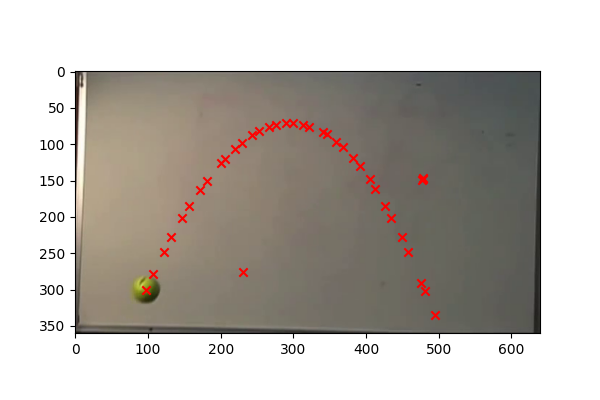

In [30]:
%matplotlib notebook

def draw_template_outline(pos, size, colors='r'):
    plt.plot([pos[0], pos[0]+size[0], pos[0]+size[0], pos[0], pos[0]],
             [pos[1], pos[1], pos[1]+size[1], pos[1]+size[1], pos[1]], c=colors)

start_frame = 40
step_frame = 10
stop_frame = ball_reader.count_frames()
template_start_pos = [72, 275]
template_size = [50, 50]

pos_frames = track_motion_static(ball_reader, start_frame, step_frame, stop_frame, template_start_pos, template_size)


fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
im = ball_reader.get_data(start_frame)
img = ax.imshow(im)
draw_template_outline(template_start_pos, template_size)

fig.canvas.draw()
plt.pause(2) # pause 2 seconds to see your choice of starting position of the template


for i in range(start_frame, stop_frame, step_frame):
    im = ball_reader.get_data(i)
    img.set_data(im)
    
    x, y = pos_frames[int((i - start_frame) / step_frame)]
    draw_template_outline([x-template_size[0]//2, y-template_size[1]//2], template_size)
    fig.canvas.draw();
    
    
## Finally, draw the final "summary" image: the starting frame with markers at all the locations
## where you found the ball on top. (That is, the markers show the trajectory of the ball.)
plt.clf()
im = ball_reader.get_data(start_frame)
plt.imshow(im)
pos_frames = np.array(pos_frames)
plt.scatter(pos_frames[:,0], pos_frames[:,1], marker='x', color='r');

In [31]:
%matplotlib inline

### 5.2 (BONUS, no points) Speeding Up Correlation based Tracking

Note: before you start working on the bonus part in this section you are advised to first finish all obligatory sections (like the next one).

We were not really *tracking* the ball. We were *finding* the ball in every frame, over and over again we did brute force searching for the ball in all positions in the image. Note that this is not so uncommon, even the most advanced deep learning systems do not have a built in notion of movement. A ball visible in frame at time $t$ will not pop up at a completely different position in frame at time $t+1$.

In the first frame, the ball position and size were given (that is, we hardcoded its location). Then, in the second frame, we searched for the ball in the entire image. But we could use a priori knowledge that the ball is moving at a maximal speed (in pixels) of, say, 100 pixels per frame. Then, given starting position $\v x_0$, we have to search only at those positions $\v x$ such that $\|\v x - \v x_0\|<100$. Assuming a standard Euclidean norm measure that would result in a circular search area. A more appropriate norm measure is the uniform or max norm $\|\v x\|_\infty$, defined by $\|\v x\|=\max\{|x_1|, \ldots, |x_n|\}$. This norm has a square "unit circle": the set of points $\v x$ with $\|\v x\|_\infty = 1$ form a square.

Now imagine that we have found the position $\v x_1$ of the ball in the frame at time $t=1$. Then we can estimate the velocity vector at time $t=1$ with $\v v_1 \approx \v x_1 - \v x_0$. So in the frame at time $t=2$ we can search for the ball in the neighborhood $\v x_1 + \v v_1$ (assuming the time difference is 1 between two frames). The size of the neighborhood then should reflect our a priori knowledge of how crude the motion model is and what errors are made and will typically lead to the neighborhood $\|\v x - (\v x_1 + \v v_1)\|_\infty < R$ where $R$ is typically smaller than the 'radius' that we had to use giving only a position and maximal speed (but no direction).

When we are done looking at frame $i$ we have $\v x_i$ and the speed $\v v_i = \v x_i - \v x_{i-1}$ and we can predict where the ball will be in frame $i+1$:
\begin{align}
\v x_{i+1} &\approx \v x_i + \v v_1
\end{align}
We then correct our prediction by looking in the neighborhood of the predicted position where the ball really is (according to the normallized correlation).

Thus incorporating a motion model that can predict where the ball will be in a next frame can decrease the size of the search area. But it doesn't always work in practice. If we had a wider and longer view of the ball and saw it bouncing on the floor, the speed would suddenly change from downward to upward and our simple tracking algorithms would have a hard time tracking the ball.

For this bonus exercise you are asked to implement the ideas described in the text above. In the resuling animation you should not only draw the box around the ball, but also the search area.

In case you are really having fun with this and want to learn more you may:

- incorporate the accelaration of the ball in your motion model (and thus prediction)

- look in the literature for *Kalman Filters* that take these ideas to the next (probabilistic) level

In [ ]:
## Your code for the bonus task goes in this cell.

### 5.3 Simulating an Optical Mouse

An optical mouse contains a camera that looks at the surface it is moving on. The resolution of the camera is quite low but because of that the frame rate is quite high. Therefore when moving the mouse, frame i and frame i+1 have a significant overlap in the area that is depicted.

The video below shows what a mouse sees when moving over a table surface (this is a simulation!)
https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/mousemovie.mp4

In [32]:
Video("https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/mousemovie.mp4", width=256)

In [33]:
if not isfile("mousemovie.mp4"):
    print("Downloading the video")
    wget.download('https://staff.fnwi.uva.nl/r.vandenboomgaard/ComputerVision/_static/mousemovie.mp4')

In [34]:
mouse_reader = imageio.get_reader("mousemovie.mp4")

Let's look at the same interactive loop to display the video frame by frame (NOTE: the video is a 'color' image, so ``rgb2gray`` is needed),

Finish the `track_motion_dynamic` function below that calculates the path that the mouse travelled. Assume that in the first frame the center of the image is at position $(0,0)$. Pick a subset of the image, using `template_pos` and `template_size`, in `start_frame` and use that as a template to look for in the next frame. The position where you found the template is indicative of the movement of the mouse. Then you select a similar template in this new frame and look for it in the next frame. Etc, etc.

The function should return a list of $(dx,dy)$ tuples indicating the movement from frame `i` to frame `i+1`.

In [35]:
def track_motion_dynamic(reader, start_frame, step_frame, end_frame, template_pos, template_size):
    """
    Find the template in all frames between start_frame and stop_frame (with an interval of step_frame). 
    Get a new template for every frame. Return a list of (x,y) tuples indicating the movement between frames.
    """
    
    center = (0,0)
    im = rgb2gray(reader.get_data(start_frame))
    old = im[template_pos[1]: template_pos[1] + template_size[1], template_pos[0]: template_pos[0] + template_size[0]]
    x = (2 * template_pos[0] + template_size[0]) / 2
    y = (2 * template_pos[1] + template_size[1]) / 2
    old_xy = (int(x),int(y))
    
    differences = []
    for i in range(start_frame + step_frame, end_frame, step_frame):
        im = rgb2gray(reader.get_data(i))
        new_xy = find_template(im, old)
        differences.append((old_xy[0] - new_xy[0], old_xy[1] - new_xy[1]))
        old = im[template_pos[1]: template_pos[1] + template_size[1], template_pos[0]: template_pos[0] + template_size[0]]
    return differences
    

In [36]:
# Tests for personal use. Codegrade will use more and different tests!
assert track_motion_dynamic(mouse_reader, 24, 1, 35, [8, 8], [16, 16]) == [(-4, 3), (-3, 3), (-4, 2), (-4, 3), (-3, 2), (-4, 3), (-4, 2), (-4, 2), (-4, 2), (-4, 1)]

<IPython.core.display.Javascript object>


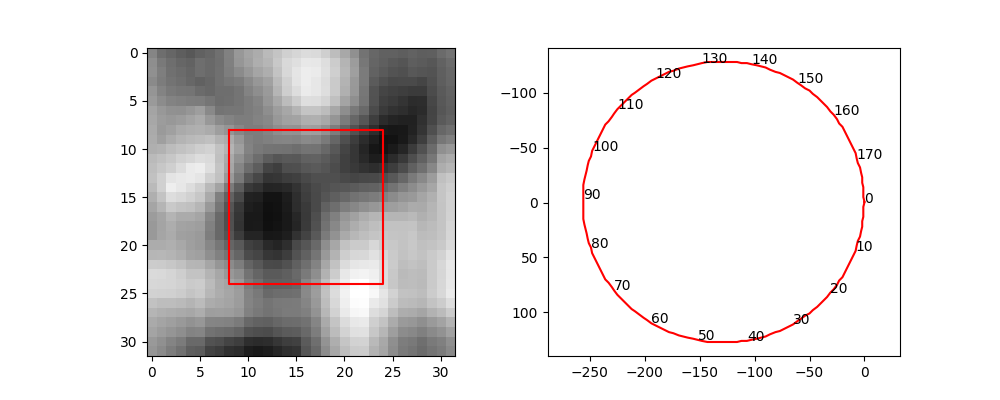

In [37]:
%matplotlib notebook

def draw_template_outline(pos, size, colors='r'):
    plt.plot([pos[0], pos[0]+size[0], pos[0]+size[0], pos[0], pos[0]],
             [pos[1], pos[1], pos[1]+size[1], pos[1]+size[1], pos[1]], c=colors)

start_frame = 0
step_frame = 1
stop_frame = mouse_reader.count_frames()

im = mouse_reader.get_data(start_frame)
ysize, xsize = im.shape[:2]
template_start_pos = [xsize//2-xsize//4, ysize//2-ysize//4]
template_size = [xsize//2, ysize//2]

dxdy = track_motion_dynamic(mouse_reader, start_frame, step_frame, stop_frame, template_start_pos, template_size)


fig = plt.figure(figsize=(10,4))
ax = plt.subplot(121)
img = ax.imshow(im)

draw_template_outline(template_start_pos, template_size)
fig.canvas.draw()
plt.pause(2) # pause 2 seconds to see your choice of starting position of the template


for i in range(start_frame, stop_frame, step_frame):
    im = mouse_reader.get_data(i)
    img.set_data(im)
    fig.canvas.draw();
       
## Finally, create the plot showing the path taken by the mouse.
plt.subplot(122)
dxdy = np.array([(0, 0)] + dxdy)
xy = np.cumsum(dxdy, axis=0)
plt.plot(xy[:,0], xy[:,1], 'r')
xy10 = xy[::10]
for i, (x, y) in enumerate(xy10):
    plt.text(x, y, str(10*i))
plt.axis('equal')
plt.gca().invert_yaxis() # note the y-axis is running from top to bottom

In [38]:
%matplotlib inline

## 6 Some Final Notes on Tracking

We have barely scratched the surface of video tracking. In case you are aiming for a system to be used in general practice you can consider the following problems for future applications.

1. How to use color information?

1. How to deal with appearance changes of the objects to be tracked? E.g. a walking person may turn around to show his back instead of front

1. How to deal with size changes? A car may overtake your car while your intelligent car is tracking it. When it gets closer in your rear view camera the car will get bigger and then when driving away from you will get smaller again (and of course first you saw the front and then the back).

1. How to deal with occlusions? A soccer player you are tracking might run behind another player being partially or completely hidden from view. 

1. When you lost track (one of the most difficult things for an intelligent system to learn: when am i lost?) how should the system recover from that. Tracking an object over a short period of time is much easier than tracking over long periods of time.

1. When i have to track objects with multiple camera's how to synchronize these intelligent camera's?

OpenCV contains a lot of trackers and there are some tutorials comparing them.